In this example we'll do hyper-parameter tuning and search with XGB and Bayes Optimization

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from xgboost import plot_tree
from bayes_opt import BayesianOptimization
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
             

XGB and Search Parameters

In [6]:
# Load the data
data = pd.read_excel('Lotto5.xlsx')

# Select the input features
features = data[['Draw', 'Odd', 'Even', '1-10', '11-20', '21-30', '31-40', 'Division 1 Winners', 'Division 2 Winners']]

# Impute missing values using KNN imputer
imputer = KNNImputer(n_neighbors=5)
features_imputed = imputer.fit_transform(features)

# Train the model
target = data[['Winning Number 1', 'Winning Number 2', 'Winning Number 3', 'Winning Number 4', 'Winning Number 5', 'Winning Number 6', 'Bonus Number']]

# Split the data into training and test sets
X_train_imputed, X_test_imputed, y_train, y_test = train_test_split(features_imputed, target, test_size=0.2, random_state=42)

# Train the XGBoost model with an evaluation set
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42)
model.fit(X_train_imputed, y_train, eval_set=[(X_test_imputed, y_test)], eval_metric='rmse', early_stopping_rounds=50, verbose=False)

# Define the objective function for Bayesian optimization
def xgb_cv(max_depth, gamma, colsample_bytree):
    params = {'n_estimators': 1000,
              'max_depth': int(max_depth),
              'gamma': gamma,
              'colsample_bytree': colsample_bytree,
              'random_state': 42}
    xgb_model = xgb.XGBRegressor(**params)
    neg_mse = -np.mean(cross_val_score(xgb_model, X_train_imputed, y_train, cv=5, scoring='neg_mean_squared_error'))
    return neg_mse

# Define the search space for hyper-parameters
xgb_bo = BayesianOptimization(xgb_cv,
                              {'max_depth': (3, 10),
                               'gamma': (0, 1),
                               'colsample_bytree': (0.3, 1)})

# Perform Bayesian Optimization to find the best hyper-parameters
xgb_bo.maximize(n_iter=10, init_points=3, acq='ei')

# Train the model using the optimized hyper-parameters
params = xgb_bo.max['params']
params['max_depth'] = int(params['max_depth'])
model = xgb.XGBRegressor(n_estimators=1000, random_state=42, **params)
model.fit(X_train_imputed, y_train, early_stopping_rounds=10, eval_set=[(X_train_imputed, y_train), (X_test_imputed, y_test)], eval_metric='rmse', verbose=False)

# Visualize the feature importance
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.xticks(range(len(model.feature_importances_)), features.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

# Visualize the training history
plt.plot(model.evals_result()['validation_0']['rmse'], label='Train')
plt.plot(model.evals_result()['validation_1']['rmse'], label='Test')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training History')
plt.legend()
plt.show


# Perform cross-validation to evaluate model performance
scores = cross_val_score(model, features_imputed, target, cv=5, scoring='neg_mean_squared_error')
print(f"Cross-validation scores: {-scores}")
print(f"Mean cross-validation score: {-np.mean(scores)}")


c:\Users\greg\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\greg\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


|   iter    |  target   | colsam... |   gamma   | max_depth |
-------------------------------------------------------------


C:\Users\greg\AppData\Local\Temp\ipykernel_35660\2351106289.py:39: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  xgb_bo.maximize(n_iter=10, init_points=3, acq='ei')


| 1         | 33.09     | 0.8292    | 0.9919    | 9.853     |
| 2         | 32.4      | 0.8965    | 0.5459    | 7.331     |
| 3         | 32.99     | 0.7604    | 0.8643    | 9.294     |
| 4         | 39.53     | 0.3       | 0.0       | 3.0       |
| 5         | 34.67     | 1.0       | 1.0       | 3.0       |
| 6         | 39.53     | 0.3       | 0.0       | 3.871     |
| 7         | 43.92     | 0.3       | 0.0       | 5.132     |
| 8         | 41.64     | 0.3       | 0.9868    | 5.211     |
| 9         | 34.6      | 1.0       | 0.0       | 5.251     |
| 10        | 41.77     | 0.3       | 0.3997    | 4.77      |
| 11        | 42.94     | 0.3       | 0.3586    | 5.646     |
| 12        | 41.16     | 0.3       | 1.0       | 6.084     |
| 13        | 44.4      | 0.3017    | 0.01807   | 5.925     |


c:\Users\greg\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
c:\Users\greg\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Cross-validation scores: [47.17610257 34.299246   35.94350526 37.70589342 47.71805611]
Mean cross-validation score: 40.56856067121733


Predicted winning numbers for set 1: [10. 15. 15. 30. 11. 18.  1.]
Predicted winning numbers for set 2: [13. 16. 20. 28.  9. 19.  3.]
Predicted winning numbers for set 3: [12. 17. 20. 30.  7. 19.  3.]
Predicted winning numbers for set 4: [11. 17. 20. 28.  7. 18.  3.]
Predicted winning numbers for set 5: [12. 17. 21. 29.  9. 19. 40.]


c:\Users\greg\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNNImputer was fitted with feature names
  warnings.warn(
c:\Users\greg\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNNImputer was fitted with feature names
  warnings.warn(
c:\Users\greg\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNNImputer was fitted with feature names
  warnings.warn(
c:\Users\greg\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNNImputer was fitted with feature names
  warnings.warn(
c:\Users\greg\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNNImputer was fitted with feature names
  warnings.warn(


100%|██████████| 100/100 [07:54<00:00,  4.74s/trial, best loss: 4.911791787978053]


c:\Users\greg\anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


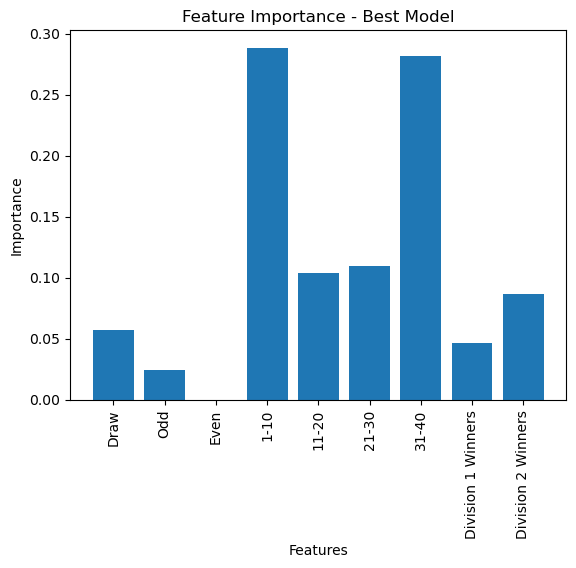

In [7]:
# Generate multiple sets of predicted numbers
num_predictions = 5
for i in range(num_predictions):
    input_data = np.random.randint(1, 50, size=(1, len(features.columns)))
    prediction = model.predict(imputer.transform(input_data))
    predicted_numbers = np.round((prediction.flatten() % 40) + 1)
    print(f"Predicted winning numbers for set {i+1}: {predicted_numbers}")

# Define the hyperparameter search space
from hyperopt import fmin, hp, tpe
space = {
    'max_depth': hp.choice('max_depth', range(1, 20)),
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.01),
    'n_estimators': hp.choice('n_estimators', range(50, 1000)),
    'subsample': hp.quniform('subsample', 0.1, 1, 0.01),
    'gamma': hp.quniform('gamma', 0, 1, 0.01),
    'reg_alpha': hp.quniform('reg_alpha', 0, 1, 0.01),
    'reg_lambda': hp.quniform('reg_lambda', 0, 1, 0.01),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1)
}

# Define the objective function for hyperparameter optimization
def objective_function(params):
    model = xgb.XGBRegressor(
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        n_estimators=int(params['n_estimators']),
        subsample=params['subsample'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        min_child_weight=int(params['min_child_weight']),
        random_state=42
    )
    scores = cross_val_score(model, features_imputed, target, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-np.mean(scores))
    return rmse

# Run the hyperparameter search using Bayesian optimization
best = fmin(fn=objective_function, space=space, algo=tpe.suggest, max_evals=100)

# Train the model with the best hyperparameters
best_model = xgb.XGBRegressor(
    max_depth=int(best['max_depth']),
    learning_rate=best['learning_rate'],
    n_estimators=int(best['n_estimators']),
    subsample=best['subsample'],
    gamma=best['gamma'],
    reg_alpha=best['reg_alpha'],
    reg_lambda=best['reg_lambda'],
    min_child_weight=int(best['min_child_weight']),
    random_state=42
)
best_model.fit(features_imputed, target, early_stopping_rounds=10, eval_set=[(features_imputed, target)], verbose=False)

# Visualize the feature importance for the best model
plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_)
plt.xticks(range(len(best_model.feature_importances_)), features.columns, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance - Best Model')
plt.show()

#Visualize the training history for the best model
plt.plot(best_model.evals_result()['validation_0']['rmse'])
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Training History - Best Model')
plt.show()


Evaluate the best model performance and generate 5 sets of results 

In [8]:
# Perform cross-validation to evaluate the performance of the best model
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error, make_scorer

scoring = make_scorer(mean_squared_error, greater_is_better=False)

cv_results = cross_validate(model, features_imputed, target, cv=5, scoring=scoring, return_estimator=True)

best_model_index = np.argmin(cv_results['test_score'])
best_model = cv_results['estimator'][best_model_index]
best_score = -cv_results['test_score'][best_model_index]

print(f"Cross-validation scores: {-cv_results['test_score']}")
print(f"Mean cross-validation score: {-np.mean(cv_results['test_score'])}")
print(f"Best cross-validation score: {best_score}")


# Generate multiple sets of predicted numbers using the best model
num_predictions = 5
for i in range(num_predictions):
    input_data = np.random.randint(1, 50, size=(1, len(features.columns)))
    prediction = best_model.predict(imputer.transform(input_data))
    predicted_numbers = np.round((prediction.flatten() % 40) + 1)
    print(f"Predicted winning numbers for set {i+1}: {predicted_numbers}")



Cross-validation scores: [47.17610257 34.299246   35.94350526 37.70589342 47.71805611]
Mean cross-validation score: 40.56856067121733
Best cross-validation score: 47.71805610753607
Predicted winning numbers for set 1: [ 9. 27. 28. 33. 24. 23.  3.]
Predicted winning numbers for set 2: [ 6. 15. 20. 30. 15. 17. 36.]
Predicted winning numbers for set 3: [10. 19. 21. 28. 15. 24. 20.]
Predicted winning numbers for set 4: [12. 16. 19. 30. 11. 15. 36.]
Predicted winning numbers for set 5: [40. 13. 14. 18. 14. 20.  8.]


c:\Users\greg\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNNImputer was fitted with feature names
  warnings.warn(
c:\Users\greg\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNNImputer was fitted with feature names
  warnings.warn(
c:\Users\greg\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNNImputer was fitted with feature names
  warnings.warn(
c:\Users\greg\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNNImputer was fitted with feature names
  warnings.warn(
c:\Users\greg\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNNImputer was fitted with feature names
  warnings.warn(
